In [1]:
%%time 

from __future__ import print_function # Use python 3 print format

# Python 2.7
%matplotlib nbagg
%matplotlib inline 

import os
import sys
print(sys.version)

import cPickle as pickle
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
# import theano
# import theano.tensor as T
# import lasagne 
# import lasagne.layers as L

import tools as tls

from sklearn.utils import shuffle
from data_loaders import svhn


2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


Using gpu device 0: GeForce GTX 950M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5004)


Wall time: 29.5 s


In [2]:
### META - HOW THE PROGRAM WORKS
f_out_name = 'data_share'
vali_size = 10000      # Size of validation set

### REDUCE SIZE
create_shared = True           
reduce_dataset_size = False     # Use reduced_size
reduce_dataset_classes = True   # Use reduced_classes
integer_encoding = True         # Are the targets integers or one-hot? (THEY ARE!)
    # NB DEPRICATED: integer_encoding = True 


reduced_size = 10000  # Max number of train/test examples
reduced_classes = 3   # Max number of classes

# OTHER THINGS
random_state = 123        # Reproducability

num_classes = 10

trai_f_name = 'train_32x32.mat'
test_f_name = 'test_32x32.mat'

data_path = os.path.join(os.getcwd(), 'data')
data_path = os.path.join(data_path,   'svhn')
data_path = os.path.join(data_path,   '')

print(data_path)


C:\Users\tokee\Documents\GitHub\02456-VAE\svhn\data\svhn\


In [12]:
%%time
### LOAD DATA
# Source: http://ufldl.stanford.edu/housenumbers/
# Download .mat files to ./data/svhn

trai_set = scipy.io.loadmat(data_path + trai_f_name )
test_set = scipy.io.loadmat(data_path + test_f_name )

t_trai = trai_set['y']
x_trai = trai_set['X']

t_test = test_set['y']
x_test = test_set['X']
print('train set', x_trai.shape, t_trai.shape)
print('test  set', x_test.shape, t_test.shape)
# plt.imshow(x_trai[:,:,:,1])


# Fix target values
t_trai[np.where(t_trai == 10)] = 0        # 0 is originally labled as 10
t_test[np.where(t_test == 10)] = 0        # 0 is originally labled as 10

# Fix input values
x_trai = x_trai.reshape((3*32*32), -1)
x_test = x_test.reshape((3*32*32, -1))
x_trai = x_trai.transpose()
x_test = x_test.transpose()


# Create validation set
# print(t_trai[42:50, :]) # Test if identical to below
x_vali = x_trai[:vali_size]; x_trai = np.delete(x_trai, range(vali_size), axis=0)
t_vali = t_trai[:vali_size]; t_trai = np.delete(t_trai, range(vali_size), axis=0)
# print(t_vali[42:50, :]) # Test if identical to above


del trai_set, test_set

# Convert to GPU firendly types
x_trai = x_trai.astype('float32')
t_trai = t_trai.astype('int32')

x_vali = x_vali.astype('float32')
t_vali = t_vali.astype('int32')

x_test = x_test.astype('float32')
t_test = t_test.astype('int32')


# Verify that shapes are as they should
print('\nAfter reshapeing')
print('train set', x_trai.shape, t_trai.shape)
print('valid set', x_vali.shape, t_vali.shape)
print('test  set', x_test.shape, t_test.shape)

print('')

train set (32L, 32L, 3L, 73257L) (73257L, 1L)
test  set (32L, 32L, 3L, 26032L) (26032L, 1L)

After reshapeing
train set (63257L, 3072L) (63257L, 1L)
valid set (10000L, 3072L) (10000L, 1L)
test  set (26032L, 3072L) (26032L, 1L)

Wall time: 8.71 s


In [13]:
%%time
### REDUCE DATA SET

if reduce_dataset_classes:
    print('Reduced number of classes, {} classes'.format(reduce_dataset_classes))
    num_classes = reduced_classes
    idxs_train = []
    idxs_valid = []
    idxs_test = []
    
    if(integer_encoding): ### IF integer encoding
        print('integer encoding')
        for i in range(num_classes):
            idxs_train += np.where(t_trai == i)[0].tolist()
            idxs_valid += np.where(t_vali == i)[0].tolist()
            idxs_test  += np.where(t_test == i)[0].tolist()
        
    else: ### IF one-hot encoding
        print('one-hot encoding')
        int_trai = np.where(t_trai == 1)[1]
        int_test = np.where(t_test == 1)[1]
        int_vali = np.where(t_vali == 1)[1]
        
        for i in range(num_classes):
            idxs_train += np.where(int_trai == i)[0].tolist()
            idxs_valid += np.where(int_vali == i)[0].tolist()
            idxs_test  += np.where(int_test == i)[0].tolist()
    
    x_trai = x_trai[idxs_train]
    t_trai = t_trai[idxs_train]
    x_trai, t_trai = shuffle(x_trai, t_trai, random_state=random_state)

    x_vali = x_vali[idxs_valid]
    t_vali = t_vali[idxs_valid]
    x_vali, t_vali = shuffle(x_vali, t_vali, random_state=random_state)

    x_test = x_test[idxs_test]
    t_test = t_test[idxs_test]

    if integer_encoding:
        t_test = tls.onehot(t_test, num_classes)  # Convert to one-hot encoding
        t_vali = tls.onehot(t_vali, num_classes)  # Convert to one-hot encoding
        t_trai = tls.onehot(t_trai, num_classes)  # Convert to one-hot encoding

    
else:
    print('Full number of classes')


if(reduce_dataset_size): ## Reduce the total size of the data set
    print('Reduce size')
    x_trai = x_trai[:reduced_size, :]
    t_trai = t_trai[:reduced_size]

    x_test = x_test[:reduced_size, :]
    t_test = t_test[:reduced_size]

    x_vali = x_vali[:reduced_size, :]
    t_vali = t_vali[:reduced_size]
else:
    print('Full size')

    
### Check that that targets are mixed as they should be
print(t_trai[:5,:], '\n')
print(t_vali[:5,:], '\n')
print(t_trai[:5,:], '\n')

### Create shared variables, improves GPU performance
if create_shared:
    print('As shared')
    x_trai, t_trai = tls.shared_dataset((x_trai, t_trai), borrow=True)
    x_vali, t_vali = tls.shared_dataset((x_vali, t_vali), borrow=True)
    x_test, t_test = tls.shared_dataset((x_test, t_test), borrow=True)
else:
    print('Not shared')

print('')

Reduced number of classes, True classes
integer encoding
Full size
[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]] 

[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]] 

[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]] 

As shared

Wall time: 1.46 s


In [14]:
### PRINT SUMMARY

if create_shared:
    print('Size of total dataset: {:.2f} MB'.format(
            (
                  sys.getsizeof(x_trai.get_value())
                + sys.getsizeof(t_trai.eval())
                + sys.getsizeof(x_vali.get_value())
                + sys.getsizeof(t_vali.eval())
                + sys.getsizeof(x_test.get_value())
                + sys.getsizeof(t_test.eval())
            )/1.0e6))

    num_features = x_trai.get_value().shape[-1]
    print('num_features {}'.format(num_features))
    print('')

    print('Train shape: ', x_trai.get_value().shape, t_trai.eval().shape)
    print('Valid shape: ', x_vali.get_value().shape, t_vali.eval().shape)
    print('Test shape:  ', x_test.get_value().shape, t_test.eval().shape)
else:
    print('Size of total dataset: {:.2f} MB'.format(
            (     sys.getsizeof(x_trai) + sys.getsizeof(t_trai)
                + sys.getsizeof(x_vali) + sys.getsizeof(t_vali)
                + sys.getsizeof(x_test) + sys.getsizeof(t_test)
            )/1.0e6))

    num_features = x_trai.shape[-1]
    print('num_features {}'.format(num_features))
    print('')

    print('Train shape: ', x_trai.shape, t_trai.shape)
    print('Valid shape: ', x_vali.shape, t_vali.shape)
    print('Test  shape: ', x_test.shape, t_test.shape)

print('')
print('{}, {}'.format(type(x_trai), type(t_trai)))
print('{}, {}'.format(type(x_vali), type(t_vali)))
print('{}, {}'.format(type(x_test), type(t_test)))


Size of total dataset: 496.75 MB
num_features 3072

Train shape:  (25362L, 3072L) (25362L, 3L)
Valid shape:  (4032L, 3072L) (4032L, 3L)
Test shape:   (10992L, 3072L) (10992L, 3L)

<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.tensor.var.TensorVariable'>
<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.tensor.var.TensorVariable'>
<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.tensor.var.TensorVariable'>


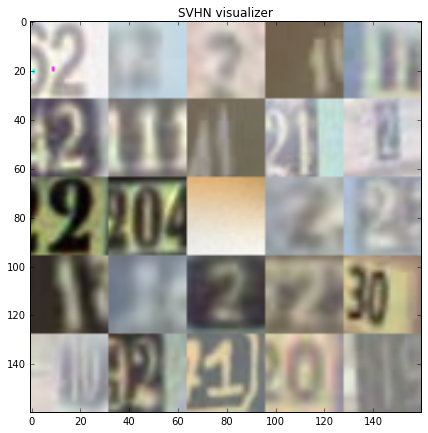

[[ 2.  2.  2.  1.  1.]
 [ 2.  1.  1.  1.  2.]
 [ 2.  0.  2.  2.  2.]
 [ 1.  1.  2.  2.  0.]
 [ 1.  2.  1.  0.  1.]]


In [17]:
### VISUALIZE DATA, ENSURE THAT EVERYTHING IS OKAY    

if create_shared:
    print(tls.plot_svhn(x_trai.get_value(), t_trai.eval(), t=5, gray=False))
else:
    print(tls.plot_svhn(x_trai, t_trai, t=5, gray=False))

In [ ]:
### CREATE DATA NAME
if reduce_dataset_classes:
    f_out_name += '_c' + str(reduced_classes)

if reduce_dataset_size:
    f_out_name += '_s' + str(reduced_size)
    
full_path = os.path.join(os.getcwd(), 'data')
full_path = os.path.join(full_path, f_out_name)
full_path  += '.pkl'
print(full_path)


In [ ]:
%%time

### SAVE DATA
with open(full_path, 'wb') as f:
    pickle.dump((x_trai, t_trai, x_vali, t_vali, x_test, t_test), 
                f, protocol=pickle.HIGHEST_PROTOCOL)
                

In [ ]:
%%time

### LOAD DATA
import cPickle as pickle
with open(full_path, 'rb') as f:
    x_trai, t_trai, x_vali, t_vali, x_test, t_test = pickle.load(f)

print('')
if create_shared:
    print('Train shape: ', 
          x_trai.get_value().shape, t_trai.eval().shape)
    print(type(x_trai))

    print('Valid shape: ', 
          x_vali.get_value().shape, t_vali.eval().shape)
    print(type(x_vali))

    print('Test shape:  ', 
          x_test.get_value().shape, t_test.eval().shape)
    print(type(x_test))
else:
    print('Train shape: ', 
          x_trai.shape, t_trai.shape)
    print(type(x_trai))

    print('Valid shape: ', 
          x_vali.shape, t_vali.shape)
    print(type(x_vali))

    print('Test shape:  ', 
          x_test.shape, t_test.shape)
    print(type(x_test))
print('')

In [ ]:
### Check that that targets are mixed as they should be
print(t_trai[:10,:])
print(t_vali[:10,:])
print(t_test[:10,:])